In [2]:
import sounddevice as sd
import time
import matplotlib.pyplot as plt
from pylab import *
#Parameters--------------
fs = 48*10**3 #48k
duration = 1.45 #seconds

In [3]:
#open all test recordings
import glob
fns = glob.glob("*.np.npy")
sigs = []
ys = []
for fn in fns:
    sigs.append( np.load(fn).flatten() )
    ys.append(fn.split('_')[3])

In [4]:
len(sigs)

44

In [74]:
def mySpec(sig,fs,nfft):
    l = range(0,len(sig)-len(sig)%nfft,nfft)
    a = np.zeros((nfft//2,len(l)))
    #sig = sig-sig.mean()
    for si, s in enumerate(l):
        ss = sig[s:s+nfft].flatten()
        a[:,si] = (np.abs(np.fft.fft(ss))/nfft)[:nfft//2] #flatten!!! otherwise it will be done over rows =SSSS
        # fuck that cost me some time =S
    freqs = np.linspace(0,fs/2,(nfft/2))
    t = np.linspace(0,(len(sig)-len(sig)%nfft)/fs,len(l))
    return a, freqs, t
    #plt.imshow((np.log(a)))

E:\Portable-Apps\PortableApps\Anaconda\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':
E:\Portable-Apps\PortableApps\Anaconda\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


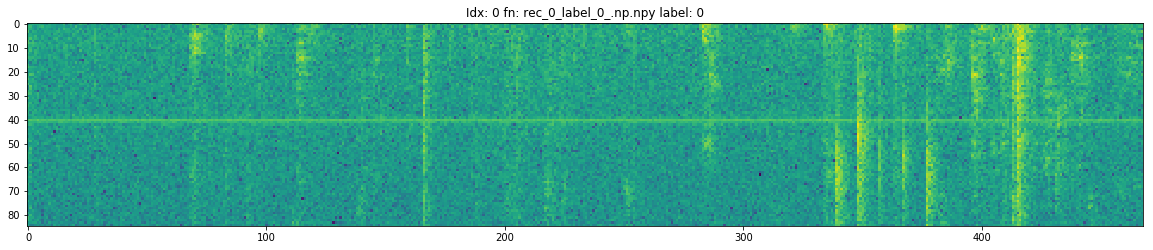

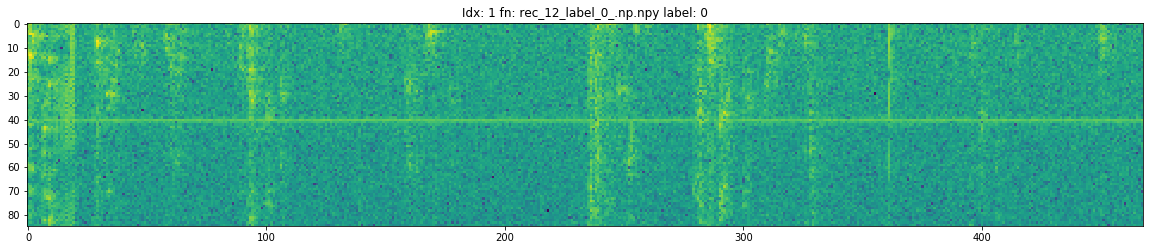

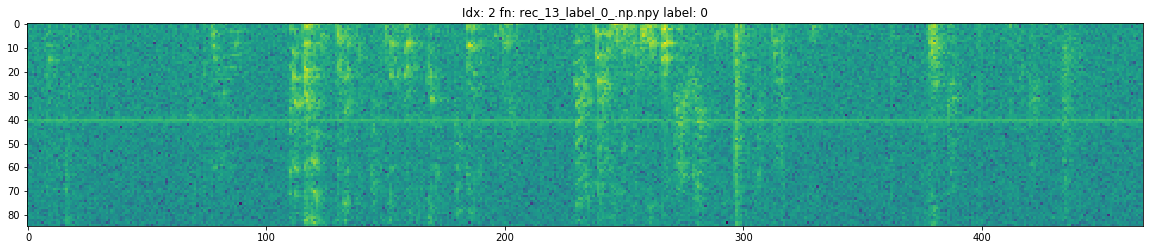

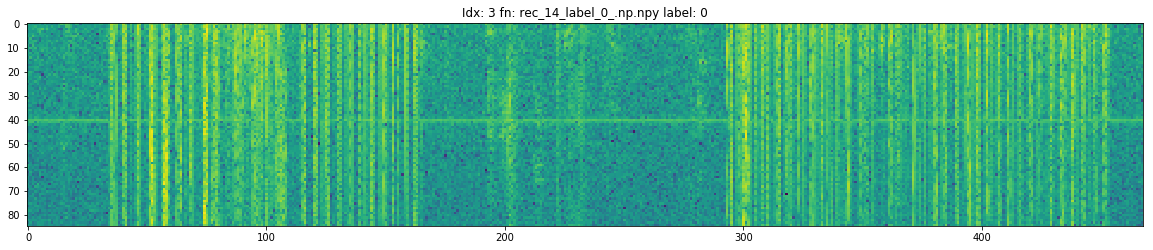

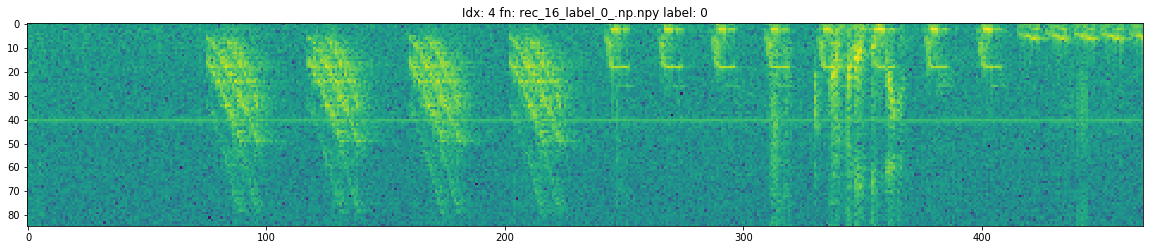

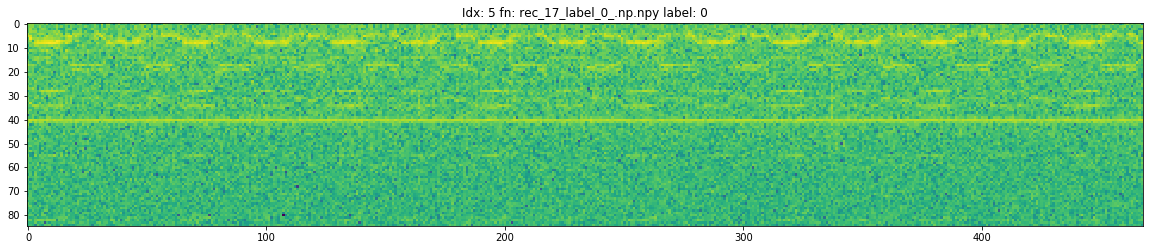

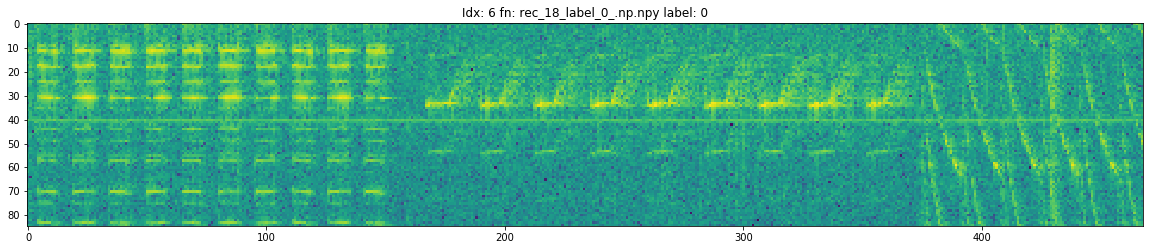

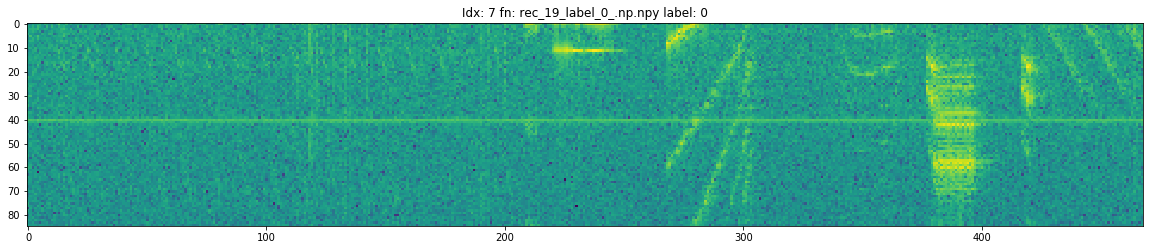

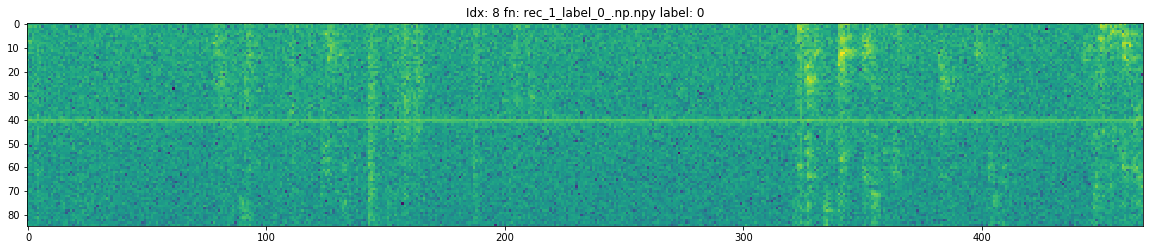

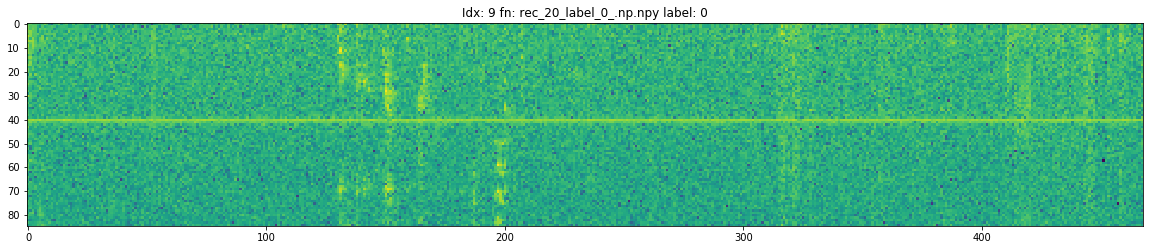

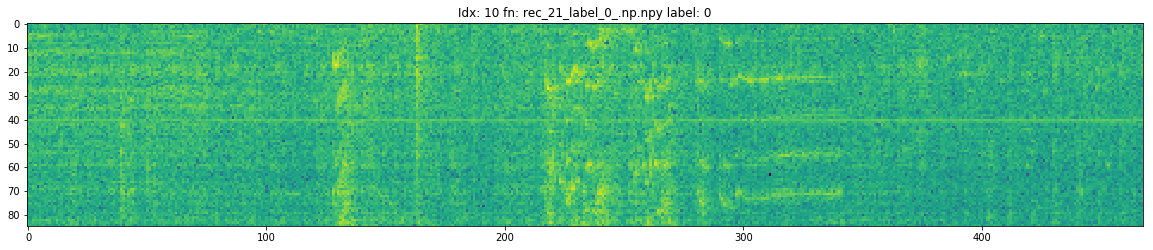

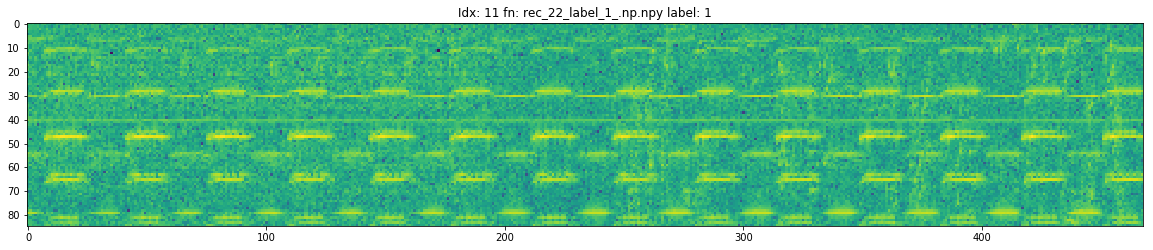

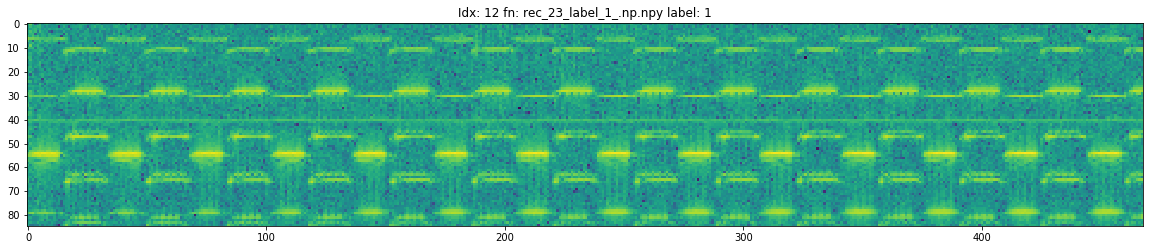

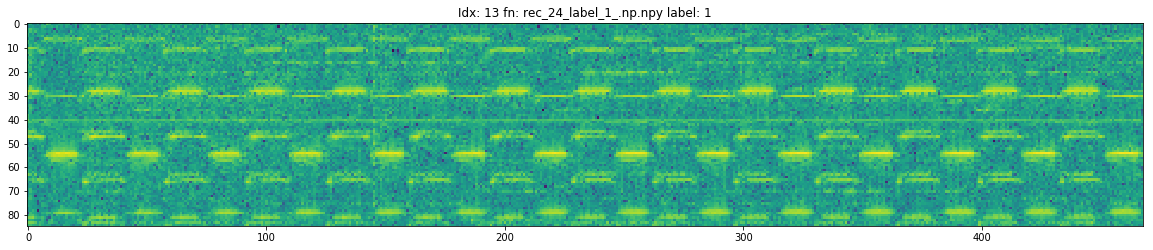

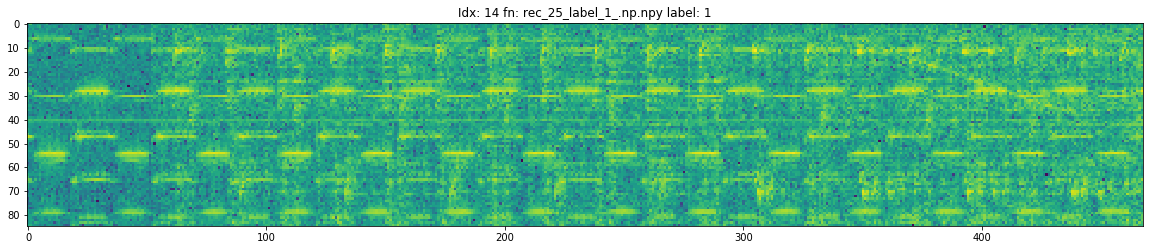

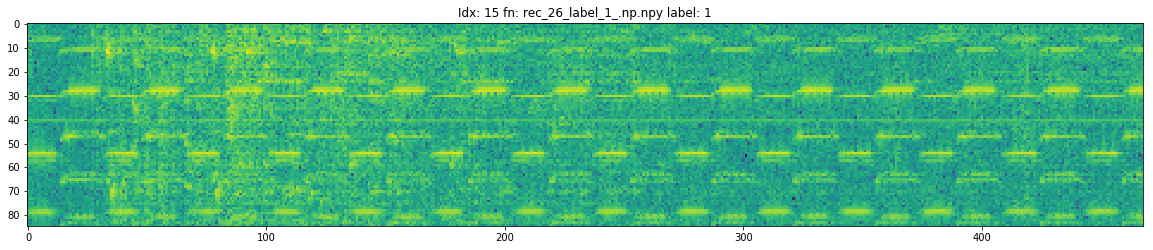

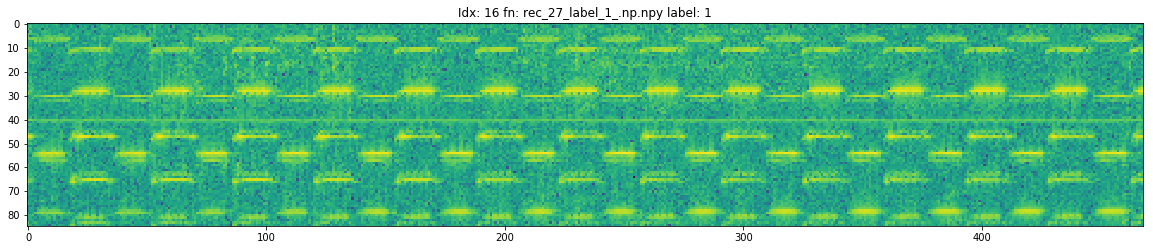

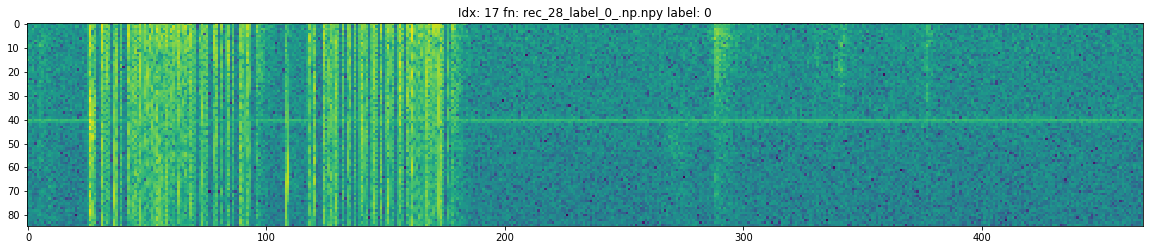

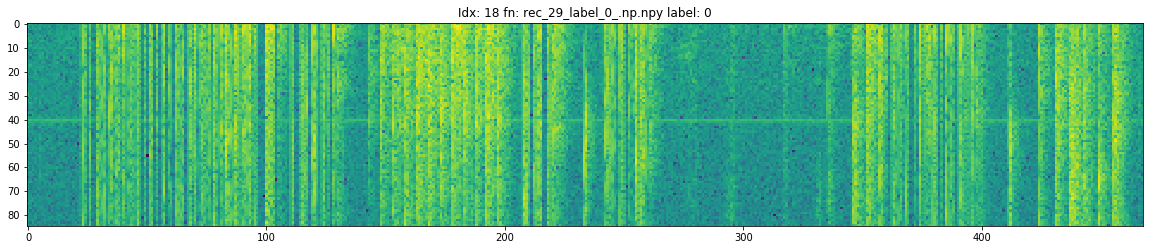

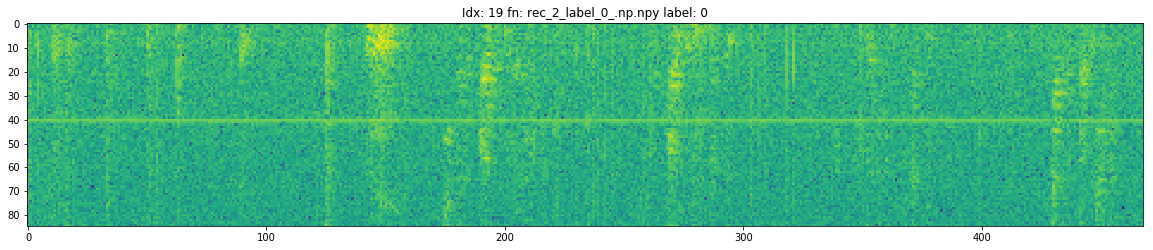

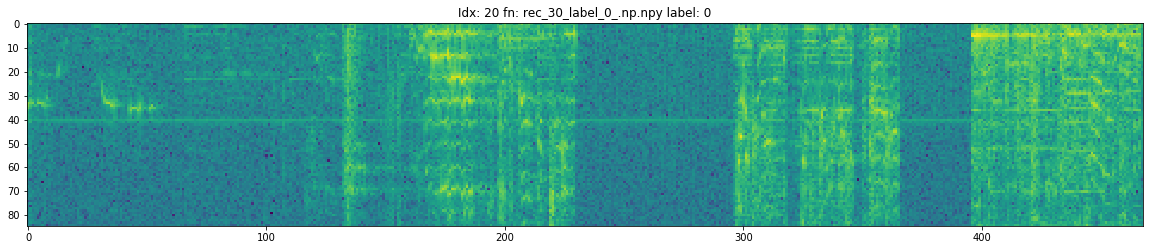

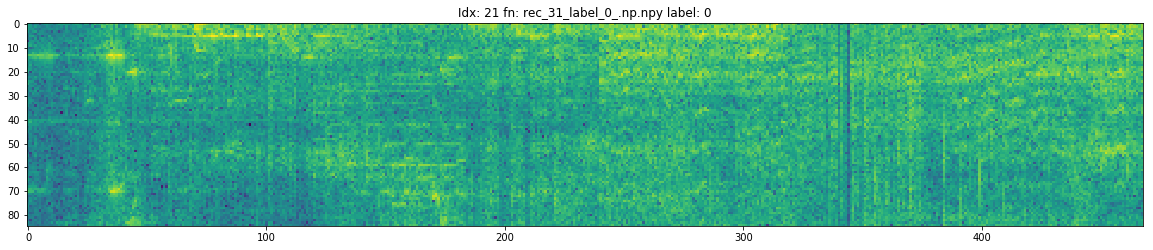

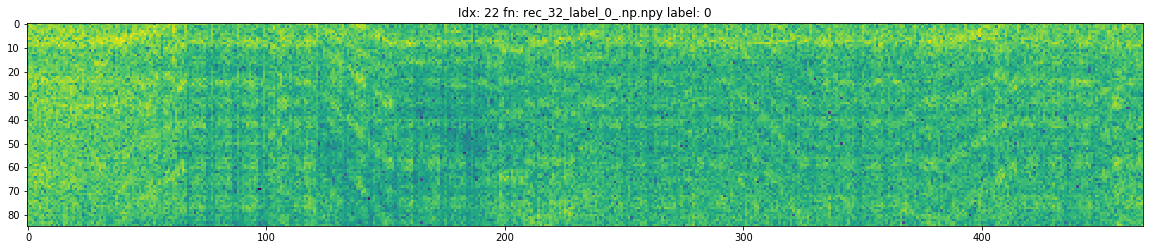

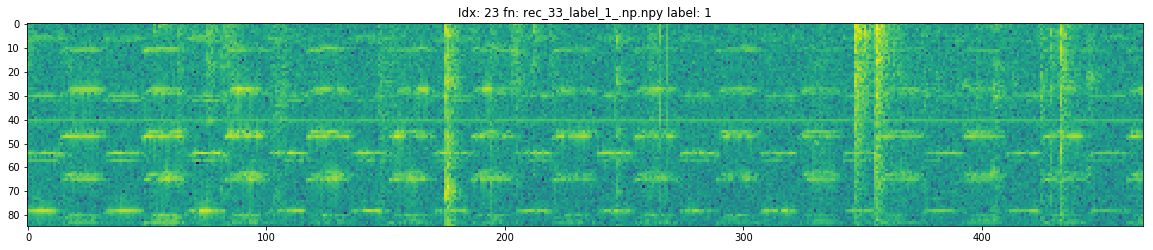

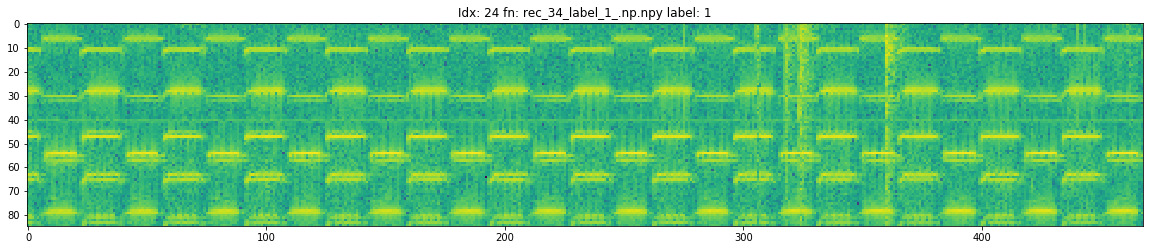

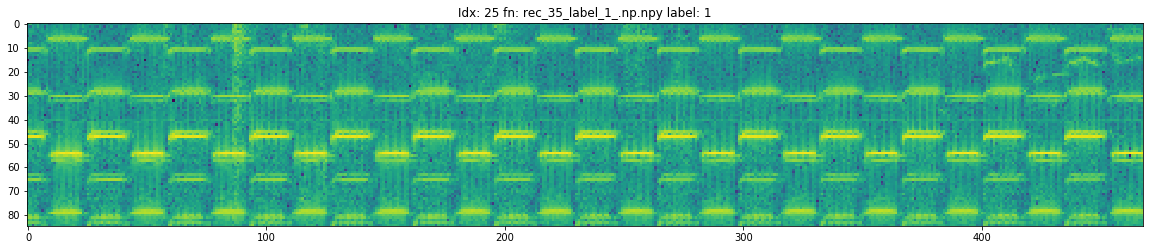

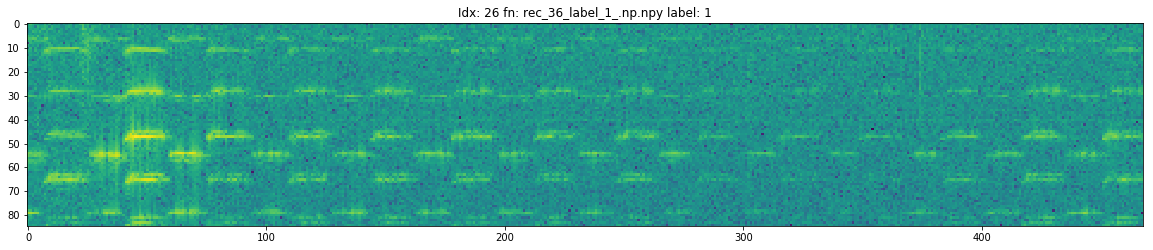

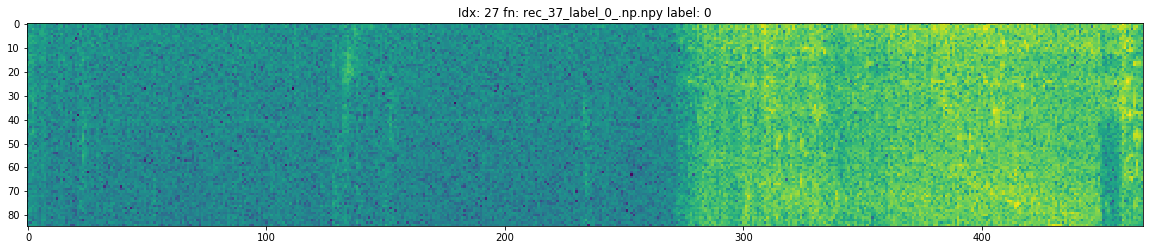

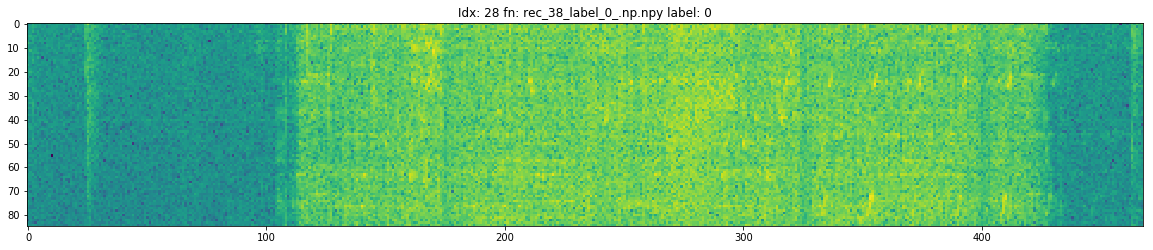

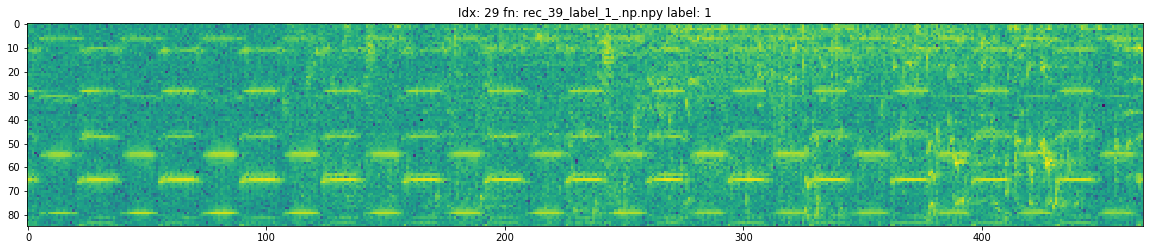

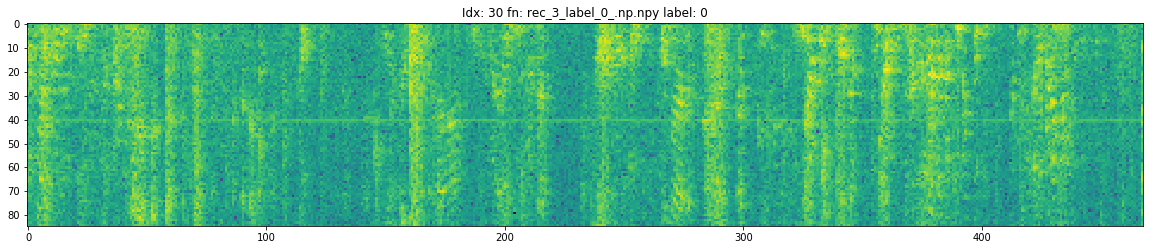

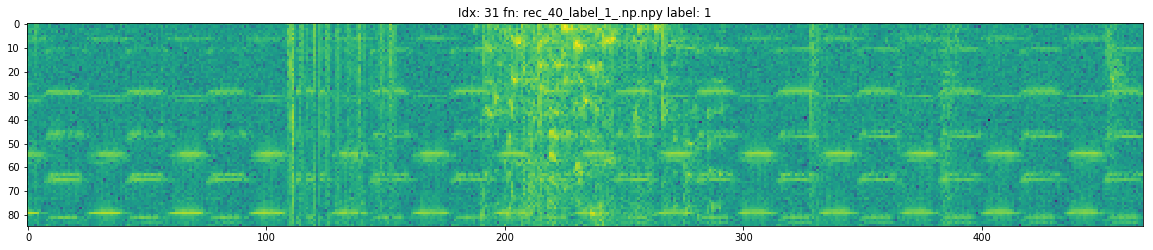

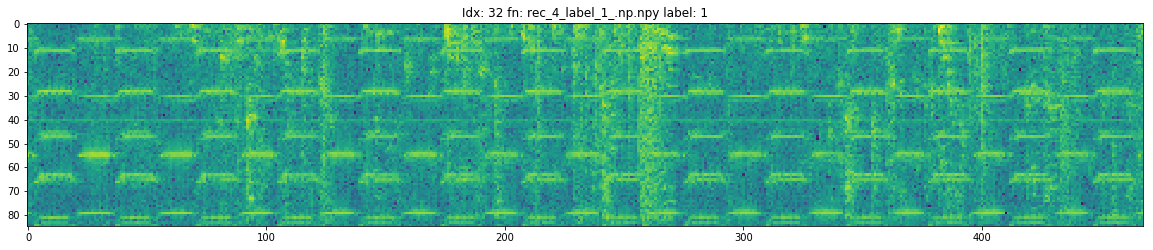

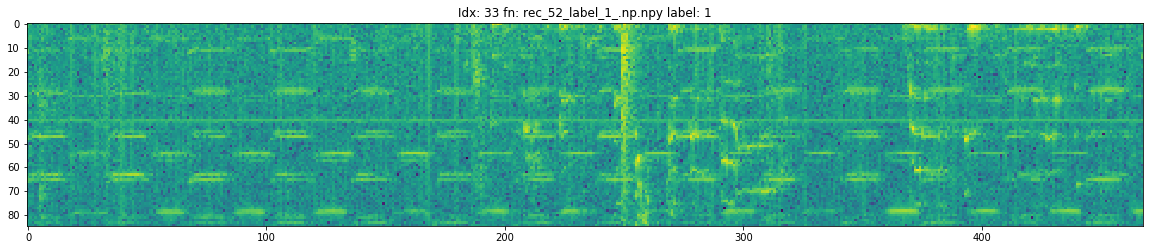

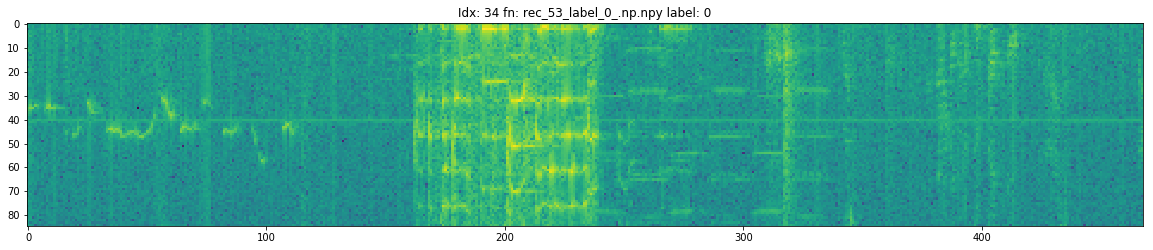

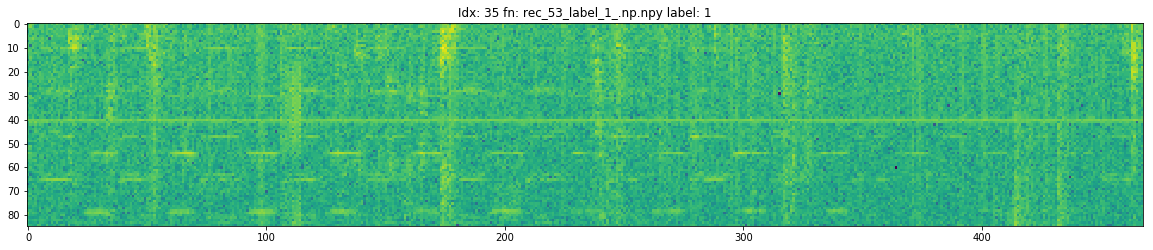

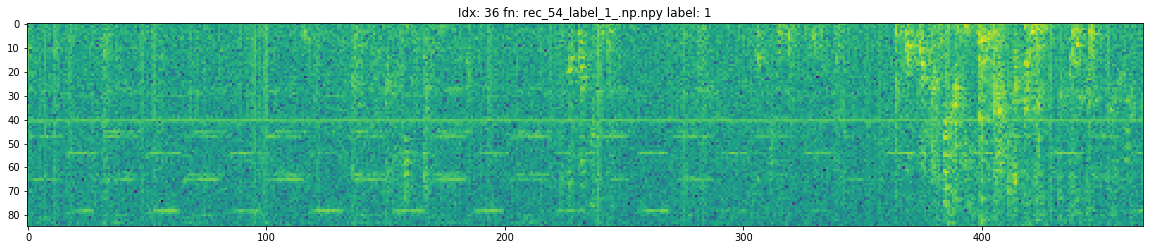

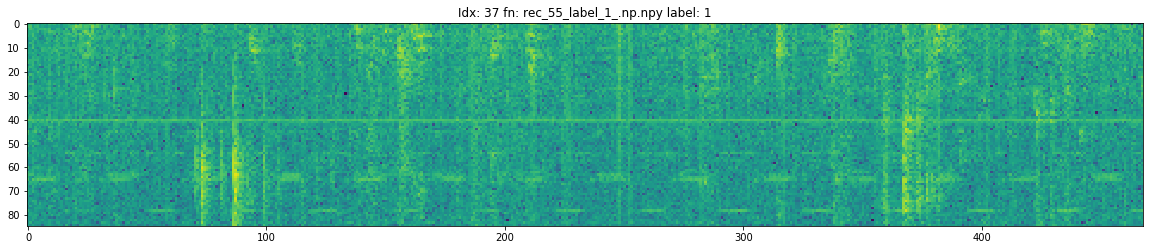

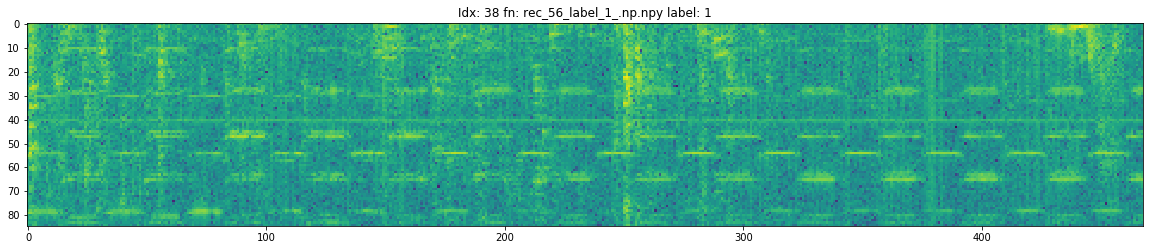

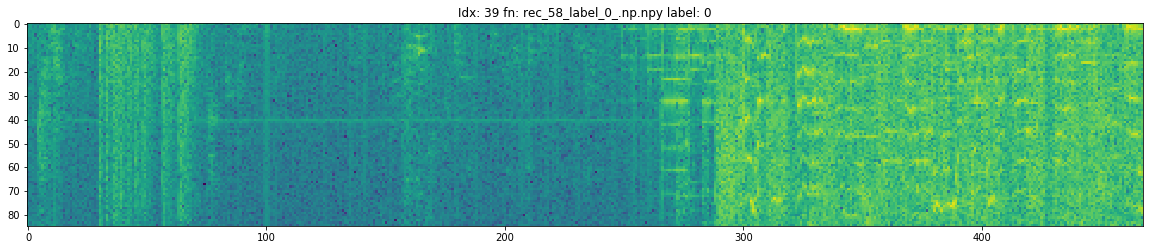

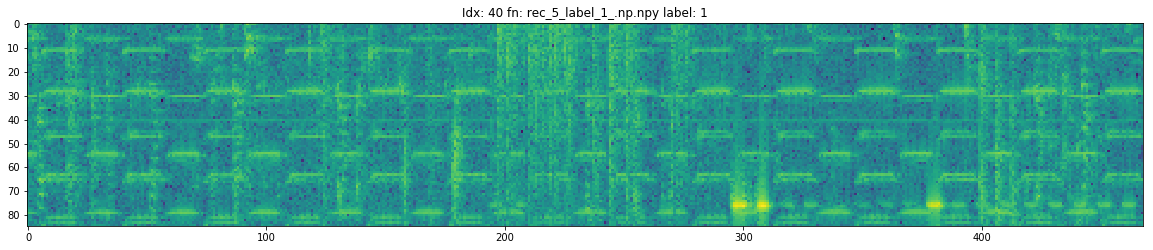

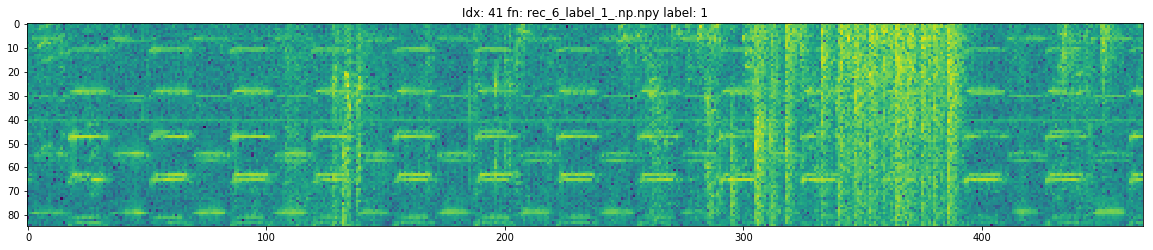

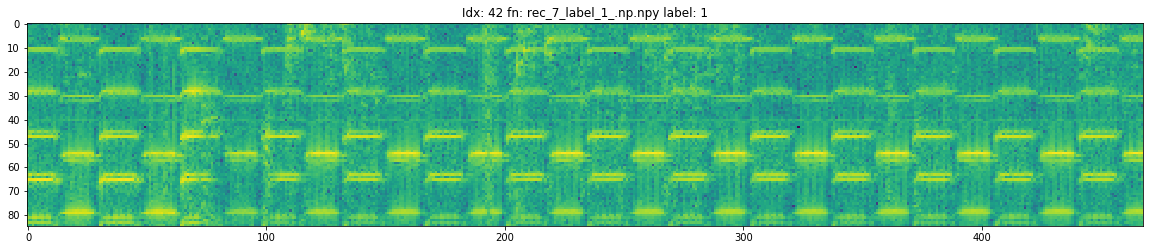

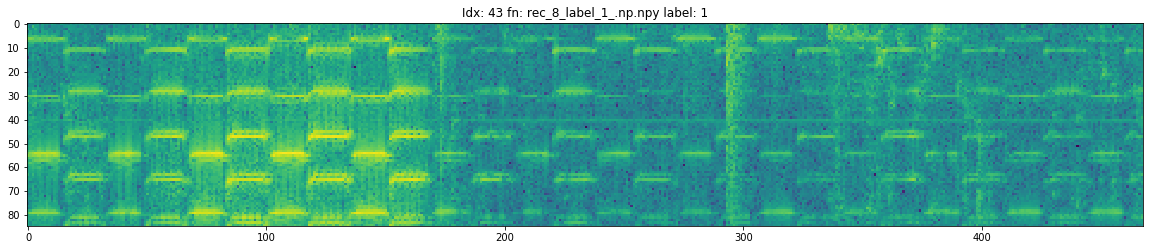

In [75]:
%matplotlib inline
X=[]
y=[]
for nn in range(len(ys)):
    sig = sigs[nn]
    plt.figure(figsize=(20,5))
    #spectrum, freqs, t, im = specgram(sig.flatten(),Fs=fs,NFFT=2**11,scale='dB',noverlap=0)
    spectrum, freqs, t = mySpec(sig.flatten(),fs,nfft=2**11)
    freqidx = (freqs>1000)*(freqs<3000)
    
    plt.imshow(np.log(spectrum[freqidx]))
    #plt.ylim((1000,3500))
    plt.title('Idx: {} fn: {} label: {}'.format(nn,fns[nn],ys[nn]))

    a=[]
    #plt.figure(figsize=(20,5))
    winSize = 1.45 #in seconds
    stepsize=0.1 #in seconds
    offs = 0
    
    l = sum(t<(winSize))
    
    for n, step in enumerate(np.arange(offs,t[-1]-winSize, stepsize)):
        tidx = (t>step).argmax()
        a.append(spectrum[freqidx][:,tidx:tidx+l])
        #plt.subplot(2,9,(n%18)+1)
        #plt.imshow(np.log(a[n]))
        #plt.title(ys[nn])
        
    X.append(a)
    y.append(np.ones(len(a))*int(ys[nn]))
X=np.log(np.asarray(X))
y=np.asarray(y)

In [5]:
sd.play(sigs[34])

In [76]:
sPerFile=X.shape[1] #samples per file
X.shape, y.mean()

((44, 186, 85, 34), 0.5)

In [77]:
X=X.reshape(-1,X.shape[2],X.shape[3])
y=y.reshape(-1)
X.shape

(8184, 85, 34)

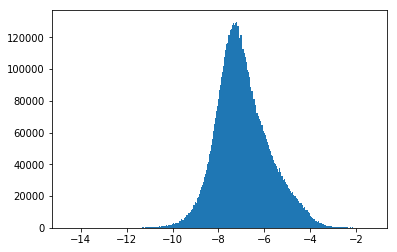

In [78]:
plt.hist(X.flatten(),bins=1000);

In [79]:
print( X.mean(), X.std() )

-6.938400280784508 1.1605078508131035


In [80]:
# scale all datapoints
#X = (X-X.mean())/X.std()
X = (X+7)/1 #15, 3

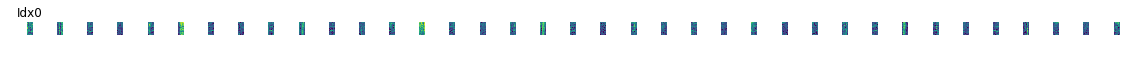

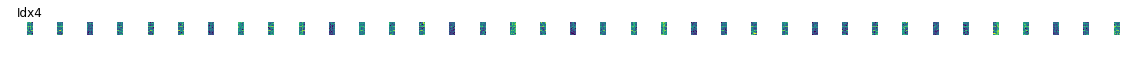

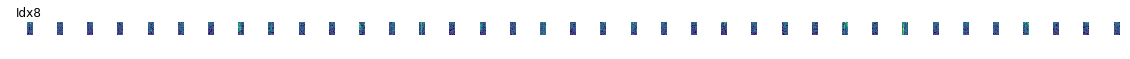

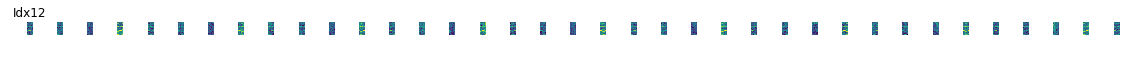

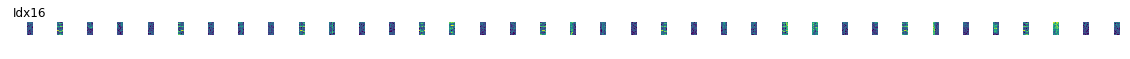

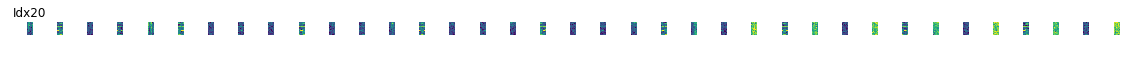

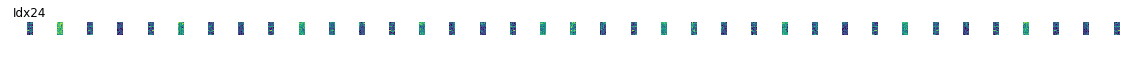

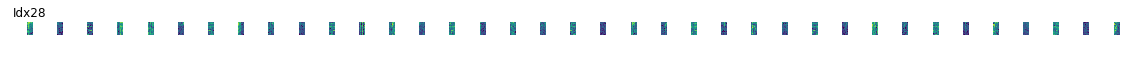

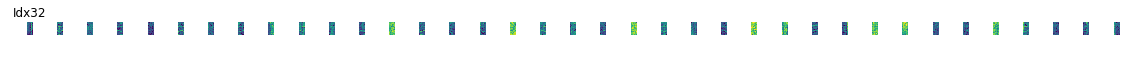

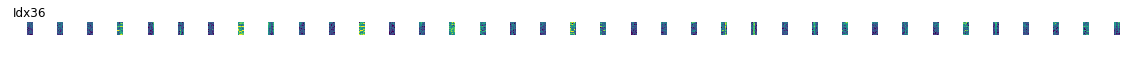

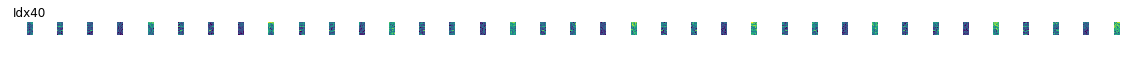

In [10]:
sn = sPerFile
for i in range(0,X.shape[0],20):
    if (i%sn)==0: plt.figure(figsize=(20,4))
    plt.subplot(1,sn,(i%sn)+1)
    plt.imshow((X[i]), vmin=-2,vmax=2)
    if (i%sn)==0:plt.title('Idx'+str(i//sn))
    if (i%sn)==1:plt.title(fns[i//sn])
    if (i%sn)==2:plt.title(ys[i//sn])
    plt.axis('off')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier
from sklearn.svm import SVC, NuSVC
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

clfs = [
    LogisticRegression(random_state=42),
    GaussianNB(),
    RandomForestClassifier(n_estimators=701,random_state=1),
    KNeighborsClassifier(n_neighbors=7),
    NuSVC(nu=0.5, kernel='rbf', degree=3),
    GradientBoostingClassifier(n_estimators=701), #,max_depth=6 learning_rate=0.00001
   # MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(128, 4), 
   #                  activation='relu', random_state=1,batch_size=16)
]
Xt = X.reshape(X.shape[0],-1)
Yt = y
for clf in clfs:
    clf_name = str(clf.__class__).split('.')[-1][:-2]
    print(clf_name, '---------------------------')
    %time scores = cross_val_score(clf, Xt, Yt, cv=5, scoring='accuracy')
    print("Val-Accuracy: %0.3f (+/- %0.3f) [%s]" % (scores.mean(), scores.std(), clf_name))

LogisticRegression ---------------------------
CPU times: user 28.2 s, sys: 1.03 s, total: 29.2 s
Wall time: 28 s
Val-Accuracy: 0.960 (+/- 0.018) [LogisticRegression]
GaussianNB ---------------------------
CPU times: user 1.63 s, sys: 496 ms, total: 2.12 s
Wall time: 2 s
Val-Accuracy: 0.864 (+/- 0.051) [GaussianNB]
RandomForestClassifier ---------------------------
CPU times: user 15min 56s, sys: 256 ms, total: 15min 56s
Wall time: 16min
Val-Accuracy: 0.943 (+/- 0.030) [RandomForestClassifier]
KNeighborsClassifier ---------------------------
CPU times: user 4min 27s, sys: 188 ms, total: 4min 28s
Wall time: 4min 28s
Val-Accuracy: 0.919 (+/- 0.047) [KNeighborsClassifier]
NuSVC ---------------------------
CPU times: user 11min 47s, sys: 232 ms, total: 11min 47s
Wall time: 11min 48s
Val-Accuracy: 0.908 (+/- 0.085) [NuSVC]
GradientBoostingClassifier ---------------------------


In [83]:
from sklearn.decomposition import PCA
Xt = PCA(n_components=9).fit_transform(X.reshape(X.shape[0],-1))
Yt = y
for clf in clfs:
    clf_name = str(clf.__class__).split('.')[-1][:-2]
    print(clf_name, '---------------------------')
    %time scores = cross_val_score(clf, Xt, Yt, cv=5, scoring='accuracy')
    print("Val-Accuracy: %0.3f (+/- %0.3f) [%s]" % (scores.mean(), scores.std(), clf_name))

LogisticRegression ---------------------------
Wall time: 161 ms
Val-Accuracy: 0.915 (+/- 0.131) [LogisticRegression]
GaussianNB ---------------------------
Wall time: 25.7 ms
Val-Accuracy: 0.927 (+/- 0.101) [GaussianNB]
RandomForestClassifier ---------------------------
Wall time: 55.5 s
Val-Accuracy: 0.914 (+/- 0.128) [RandomForestClassifier]
KNeighborsClassifier ---------------------------
Wall time: 467 ms
Val-Accuracy: 0.868 (+/- 0.170) [KNeighborsClassifier]
NuSVC ---------------------------
Wall time: 21.1 s
Val-Accuracy: 0.668 (+/- 0.074) [NuSVC]
GradientBoostingClassifier ---------------------------
Wall time: 28.5 s
Val-Accuracy: 0.891 (+/- 0.163) [GradientBoostingClassifier]


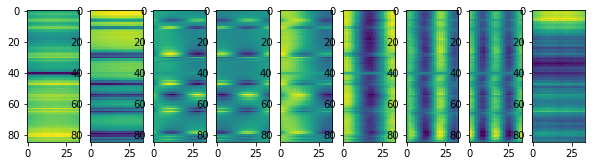

In [84]:
# look at the components
pca = PCA(n_components=9)
pca.fit(X.reshape(X.shape[0],-1))

plt.figure(figsize=(10,5))
for i in range(9):
    plt.subplot(1,9,i+1)
    plt.imshow(pca.components_[i].reshape(X.shape[1],-1))

In [85]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(pca.transform(X.reshape(X.shape[0],-1)),y)

GaussianNB(priors=None)

In [86]:
from sklearn.externals import joblib
joblib.dump(pca, 'pca.pkl')
joblib.dump(nb,'nb_pca.pkl')

['nb_pca.pkl']

In [94]:
Xt = X.reshape(X.shape[0],-1)
Yt = y
lr =  LogisticRegression(random_state=42)
lr.fit(Xt,Yt)
from sklearn.externals import joblib
joblib.dump(lr, 'alarm_lr_clf2.pkl')

['alarm_lr_clf2.pkl']

In [ ]:
clfs[2].fit(Xt,Yt)
from sklearn.externals import joblib
joblib.dump(clfs[0], 'alarm_rf_clf.pkl')

In [88]:
clf = clfs[0]
clf.intercept_

array([2.14275369])

In [89]:
# create model
from keras.models import Sequential
from keras.layers import Dense, Activation, AlphaDropout, Embedding, Dropout, Flatten
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, Callback
# cnn
from keras.layers import Conv2D, GlobalMaxPooling1D,GlobalAveragePooling1D, MaxPooling2D
from keras.callbacks import EarlyStopping
cb = [EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=5, verbose=1, mode='auto')]

#HYPERPARM:
kernSiz = (30,30)#layer 1 (??has to be devidable be nrDays)
strides = (1,1) #layer 1

cnn = Sequential()
cnn.add(Conv2D(input_shape=(X.shape[1],X.shape[2],1), filters=256, kernel_size=kernSiz, strides=strides)) 
cnn.add(MaxPooling2D(pool_size=2, strides=None, padding='valid'))
cnn.add(Dropout(0.3))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
cnn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
cnn.fit(X.reshape(-1,X.shape[1],X.shape[2],1), y, batch_size=3, epochs=1, verbose=1, validation_split=0.2, callbacks=cb) #silent with verbose

#pred = clf.predict_proba(X_test.reshape(X_test.shape[0],-1,1))[:,0]

Using TensorFlow backend.


Train on 6547 samples, validate on 1637 samples
Epoch 1/1
6547/6547 [==============================] - 173s 26ms/step - loss: 0.0900 - acc: 0.9711 - val_loss: 1.3177 - val_acc: 0.6982


In [90]:
Xt.shape

(8184, 9)

In [91]:
import keras
input_shape=(X.shape[1],X.shape[2],1)

kernel_sizes = [(3,3),(5,5),(7,7),(9,9),(11,11),(13,13)] #9x9 shoed the best val_acc
activations = ['tanh','relu','selu'] #sigmoid was bad :S # tanh was best
#keras.layers.ReLU(max_value=None)
histys=[] 

#print('KernelSize: ',act,' --------------')
model = Sequential()
model.add(Conv2D(32, kernel_size=(9,9),
                 activation='tanh',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

hist = model.fit(X.reshape(-1,X.shape[1],X.shape[2],1), y,
          batch_size=2**10,
          epochs=10,
          verbose=1,
          validation_split=0.2)

Train on 6547 samples, validate on 1637 samples
Epoch 1/10
6547/6547 [==============================] - 43s 7ms/step - loss: 0.6615 - acc: 0.6495 - val_loss: 0.6848 - val_acc: 0.6432
Epoch 2/10
6547/6547 [==============================] - 40s 6ms/step - loss: 0.2870 - acc: 0.9000 - val_loss: 0.4885 - val_acc: 0.6842
Epoch 3/10
6547/6547 [==============================] - 39s 6ms/step - loss: 0.0914 - acc: 0.9740 - val_loss: 0.5288 - val_acc: 0.7593
Epoch 4/10
6547/6547 [==============================] - 40s 6ms/step - loss: 0.0692 - acc: 0.9840 - val_loss: 0.6058 - val_acc: 0.7654
Epoch 5/10
6547/6547 [==============================] - 39s 6ms/step - loss: 0.0650 - acc: 0.9844 - val_loss: 0.6039 - val_acc: 0.7502
Epoch 6/10
6547/6547 [==============================] - 41s 6ms/step - loss: 0.0519 - acc: 0.9847 - val_loss: 0.5204 - val_acc: 0.7440
Epoch 7/10
6547/6547 [==============================] - 43s 7ms/step - loss: 0.0476 - acc: 0.9849 - val_loss: 0.4573 - val_acc: 0.7685
Epoch 8

In [92]:
model.fit(X.reshape(-1,X.shape[1],X.shape[2],1), y,
          batch_size=2**9,
          epochs=3,
          verbose=1)

Epoch 1/3
8184/8184 [==============================] - 44s 5ms/step - loss: 0.1259 - acc: 0.9585
Epoch 2/3
8184/8184 [==============================] - 44s 5ms/step - loss: 0.0885 - acc: 0.9748
Epoch 3/3
8184/8184 [==============================] - 43s 5ms/step - loss: 0.0793 - acc: 0.9783


In [93]:
model.save('cnn_new.h5')

In [43]:
X[1].shape

(85, 34)

In [42]:
model.predict(X[1].reshape(-1,X.shape[1],X.shape[2],1))[0][0]

6.6828555e-08

In [16]:
2**7

128

# save Keras Model as tf-model

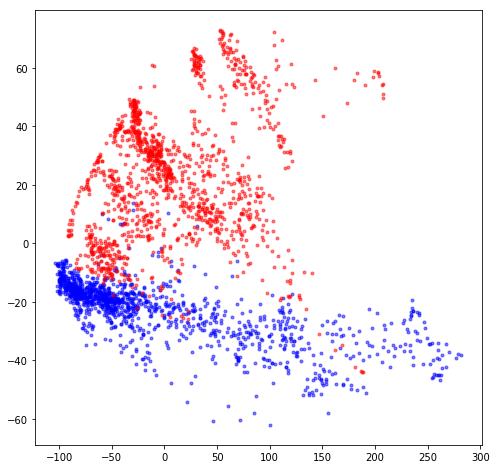

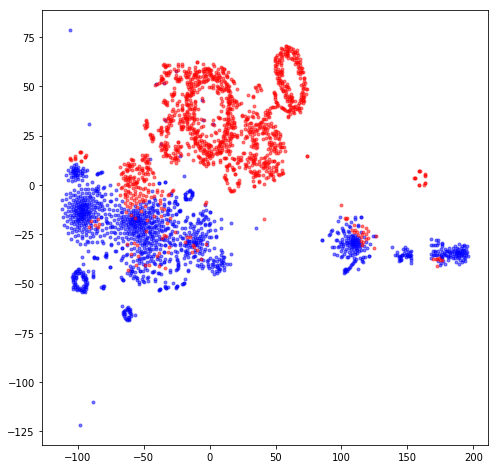

In [23]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn import manifold
decomps = [PCA(n_components=2),
           #manifold.SpectralEmbedding(n_components=2),
           manifold.TSNE(n_components=2, init='pca')]

evry = 3 #just uses every evry sample
for dec in decomps:
    t=dec.fit_transform(X.reshape(X.shape[0],-1)[::evry])
    plt.figure(figsize=(8,8))
    plt.plot(t[(y[::evry]==0),0],t[(y[::evry]==0),1],'b.', alpha=0.5)
    plt.plot(t[(y[::evry]==1),0],t[(y[::evry]==1),1],'r.',alpha=0.5)
    plt.show()

In [36]:
import keras

from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io

from keras.models import Model, load_model
model.get

AttributeError: module 'keras' has no attribute 'get_session'

In [ ]:
model=load_model("model.hd5")

constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)

output="graph.pb"
graph_io.write_graph(constant_graph, "/", output, as_text=False)
print('saved the freezed graph (ready for inference) at: ', output)

In [75]:
X.shape

(182, 85, 34)

# STUFF

In [ ]:
n=6
sig = sigs[n]
offs=1.6
sig = sig[int(offs*fs):int((offs+1.5)*fs)]
print(ys[n])
spectrum, freqs, t, im = specgram(sig.flatten(),Fs=fs,NFFT=2**11,scale='dB',noverlap=0)
plt.ylim((1000,3000))

plt.figure(figsize=(20,5))
intrIdx = [90,98,108]
for idx in intrIdx:
    plt.plot(spectrum[idx,:])

plt.figure(figsize=(20,5))
intrIdx = [90,97,108]
al = []
for idx in intrIdx:
    ff = np.fft.fft(spectrum[idx,:])
    plt.plot(np.abs(ff)) 
    al.append(ff[14])
plt.xlim((0,40))
plt.legend(intrIdx)
#print(al.sum)